### 데이터 불러오기

In [89]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import rcParams, font_manager

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [90]:
# train, test 데이터를 불러옵니다.
path = '/Users/yniyunj/Desktop/AI/250115-EVpriceprediction'
train = pd.read_csv(path+'/open/train.csv')
test = pd.read_csv(path+'/open/test.csv')

In [91]:
# 한글 폰트 파일 경로 지정
font_path = "/Users/yniyunj/Library/Fonts/NanumGothic-Regular.ttf"  # 설치된 폰트 경로
font_prop = font_manager.FontProperties(fname=font_path)

# Matplotlib 설정
rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

print("현재 설정된 폰트:", plt.rcParams['font.family'])

현재 설정된 폰트: ['NanumGothic']


In [92]:
train.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


### 데이터 살펴보기

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램을 여러 개 그리는 함수
def plot_histograms(data, columns_to_plot, cols=2, figsize=(15, 10)):
    rows = (len(columns_to_plot) + cols - 1) // cols  # 필요한 행 수 계산
    fig, axes = plt.subplots(rows, cols, figsize=figsize)  # 서브플롯 생성
    axes = axes.flatten()  # 2D 배열을 1D 배열로 변환

    for i, column in enumerate(columns_to_plot):
        if data[column].dtype == 'object':  # 범주형 데이터
            sns.countplot(data=data, x=column, ax=axes[i])
        else:  # 연속형 데이터
            sns.histplot(data[column], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {column}', fontsize=14)
    
    # 남은 빈 플롯 제거
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

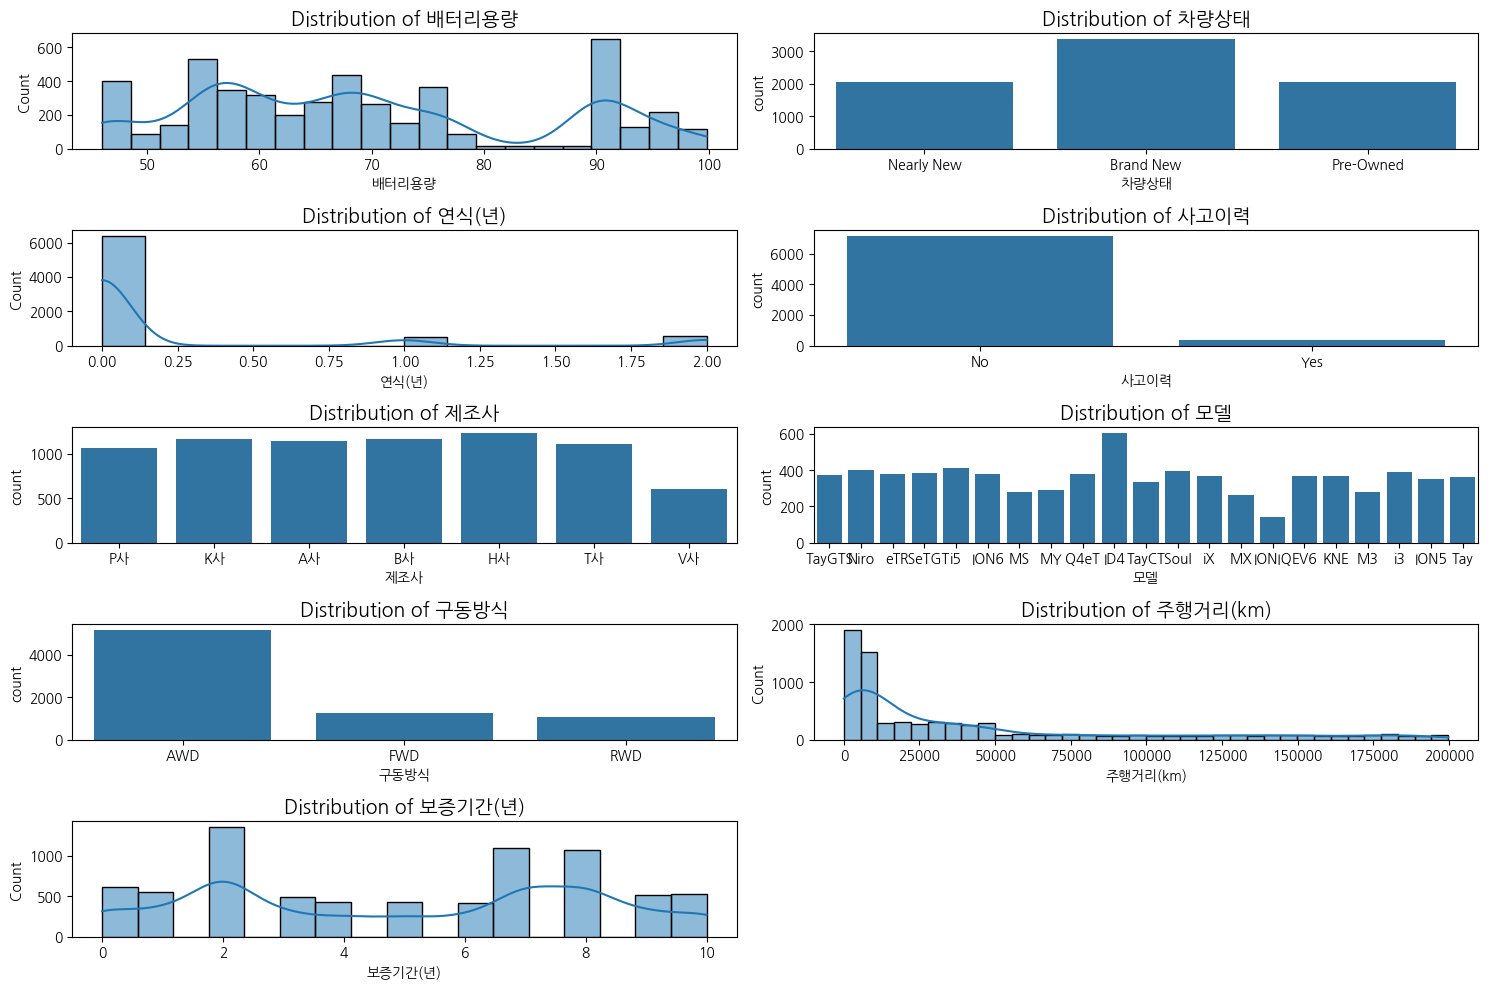

In [94]:
# 사용할 열 리스트
columns_to_plot = ['배터리용량', '차량상태', '연식(년)', '사고이력', '제조사', '모델', '구동방식', '주행거리(km)', '보증기간(년)']

# 함수 실행: 한 행에 2개씩 그래프 생성
plot_histograms(data=train, columns_to_plot=columns_to_plot, cols=2, figsize=(15, 10))

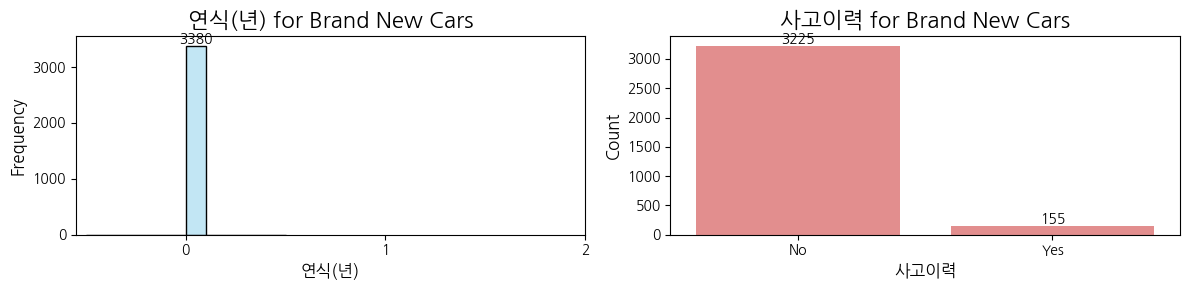

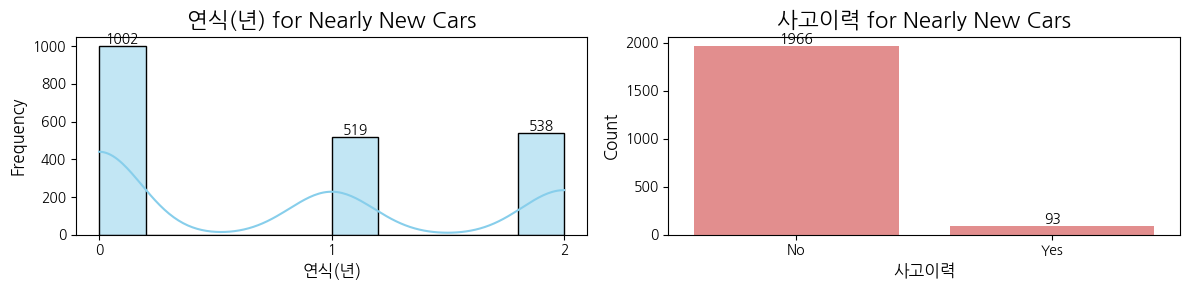

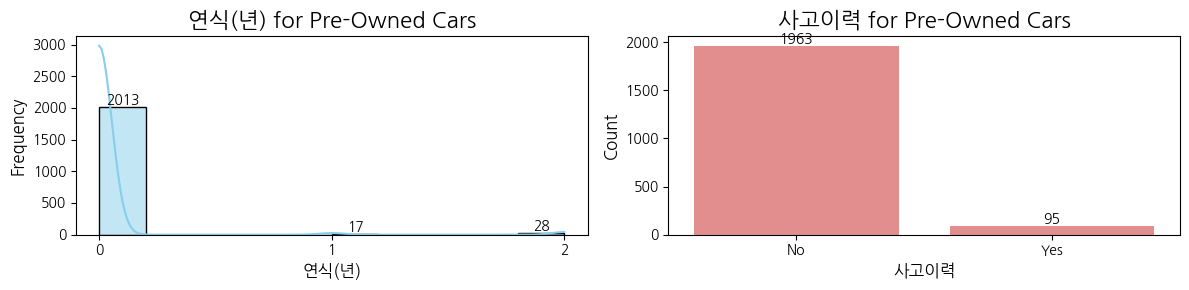

In [95]:
lst = ['Brand New', 'Nearly New', 'Pre-Owned']

for i in lst:
    # 특정 차량 상태 필터링
    brand_new_cars = train[train['차량상태'] == i]

    # 한 행에 두 개의 그래프를 표시
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))  # 1행 2열 서브플롯

    # 차량의 연식 시각화
    sns.histplot(brand_new_cars['연식(년)'], kde=True, bins=10, color='skyblue', ax=axes[0])
    axes[0].set_title(f'연식(년) for {i} Cars', fontsize=16)
    axes[0].set_xlabel('연식(년)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_xticks([0, 1, 2])
    # y값을 자동으로 표시
    for bar in axes[0].containers:
        labels = [f'{int(val)}' if val > 0 else '' for val in bar.datavalues]
        axes[0].bar_label(bar, labels=labels, label_type='edge', fontsize=10)

    # 차량의 사고이력 시각화
    sns.countplot(x=brand_new_cars['사고이력'], ax=axes[1], color='lightcoral')  # `color` 사용
    axes[1].set_title(f'사고이력 for {i} Cars', fontsize=16)
    axes[1].set_xlabel('사고이력', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    # y값을 표시
    for bar in axes[1].containers:
        labels = [f'{int(val)}' if val > 0 else '' for val in bar.datavalues]
        axes[1].bar_label(bar, labels=labels, label_type='edge', fontsize=10)

    # 레이아웃 조정
    plt.tight_layout()
    plt.show()

### Train 데이터 중 Brand New이면서 사고이력 Yes는 무엇인가?

In [96]:
# 연식(년)이 0이고 사고이력이 있는 데이터 필터링
train_suspicious_data = train[(train['차량상태'] == 'Brand New') & (train['사고이력'] == 'Yes')]
train_suspicious_data.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
13,TRAIN_0013,K사,Niro,Brand New,NaN,AWD,1191,10,Yes,0,21.36
116,TRAIN_0116,B사,i5,Brand New,NaN,AWD,4692,8,Yes,0,65.94
165,TRAIN_0165,H사,ION6,Brand New,NaN,AWD,1573,9,Yes,0,38.94
195,TRAIN_0195,K사,Niro,Brand New,NaN,FWD,7300,9,Yes,0,24.98
232,TRAIN_0232,B사,i3,Brand New,NaN,AWD,8648,7,Yes,0,24.38


### Test에도 Brand New이면서 사고이력이 Yes인 값들이 있나?

- 들어있음.. 이것을 어떻게 해석할 것인가
    - Brand New의 정의가 단순히 **공장에서 출고된 새 차량**이 아니라, **판매 전 차량**을 포함할 수 있음
    - 판매 전 차량은 전시, 테스트주행, 운송거리 등으로 인해서 주행거리가 기록될 수 있음

In [97]:
# 연식(년)이 0이고 사고이력이 있는 데이터 필터링
test_suspicious_data = test[(test['차량상태'] == 'Brand New') & (test['사고이력'] == 'Yes')]
test_suspicious_data.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
25,TEST_025,K사,EV6,Brand New,NaN,FWD,3987,10,Yes,0
72,TEST_072,T사,MS,Brand New,99.8,AWD,1624,8,Yes,0
116,TEST_116,T사,MY,Brand New,NaN,AWD,8163,7,Yes,0
177,TEST_177,K사,EV6,Brand New,90.0,AWD,7196,10,Yes,0


In [98]:
print(train_suspicious_data['주행거리(km)'].describe())
print(test_suspicious_data['주행거리(km)'].describe())

count     155.000000
mean     4775.219355
std      3023.850266
min        30.000000
25%      1971.500000
50%      4853.000000
75%      7185.500000
max      9969.000000
Name: 주행거리(km), dtype: float64
count      21.000000
mean     5389.952381
std      2980.434507
min       563.000000
25%      3382.000000
50%      6143.000000
75%      7769.000000
max      9935.000000
Name: 주행거리(km), dtype: float64


### 새로운 파생변수(Brand New인데 사고이력이 있는 것들) 생성

- Train과 Test에 모두 이러한 데이터가 있으므로 일방적으로 삭제하는 것보다 파생변수를 생성하는 것이 좋을 것으로 판단함

In [99]:
# True면 1, False면 2
train['BrandNew_Accident'] = ((train['차량상태'] == 'Brand New') & (train['사고이력'] == 'Yes')).astype(int)
test['BrandNew_Accident'] = ((test['차량상태'] == 'Brand New') & (test['사고이력'] == 'Yes')).astype(int)

In [100]:
train.head(3)

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),BrandNew_Accident
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66,0
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,0
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27,0


### Train 레이블 인코딩

In [101]:
encoded_train = train.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_train.columns if encoded_train[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_train[col])
    encoded_train[col] = le.transform(encoded_train[col])
    
# 결과 확인
print(encoded_train.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)  가격(백만원)  \
0   0    4  16     1  86.077     0     13642        0     0      2   159.66   
1   1    3  10     1  56.000     1     10199        6     0      0    28.01   
2   2    0  17     0  91.200     0      2361        7     0      0    66.27   
3   3    0  12     1     NaN     0     21683        3     0      0    99.16   
4   4    1  19     2  61.018     0    178205        1     0      0    62.02   

   BrandNew_Accident  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


### Test 레이블인코딩

In [102]:
encoded_test = test.copy()
# 범주형 열 확인
categorical_features = [col for col in encoded_test.columns if encoded_test[col].dtype == 'object']

# 레이블 인코딩 적용
for col in categorical_features:
    le = LabelEncoder()
    le.fit(encoded_test[col])
    encoded_test[col] = le.transform(encoded_test[col])
    
# 결과 확인
print(encoded_test.head())

   ID  제조사  모델  차량상태   배터리용량  구동방식  주행거리(km)  보증기간(년)  사고이력  연식(년)  \
0   0    4  15     1  76.093     0     14057        2     0      0   
1   1    1  20     0  90.000     0      7547        8     0      0   
2   2    1  19     0     NaN     2      7197        7     1      0   
3   3    2   2     1  68.479     0     10357        7     0      1   
4   4    3   0     0     NaN     1      7597       10     0      0   

   BrandNew_Accident  
0                  0  
1                  0  
2                  1  
3                  0  
4                  0  


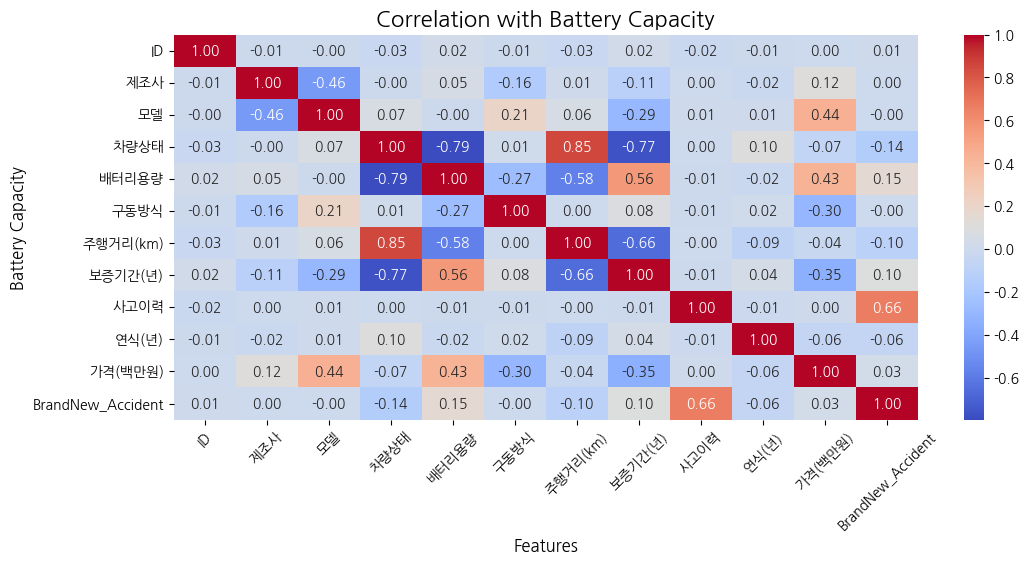

In [103]:
# '배터리용량'과 다른 변수 간의 상관계수 계산
battery_corr = encoded_train.corr()

# 상관계수 히트맵 시각화
plt.figure(figsize=(12, 5))
sns.heatmap(battery_corr.T, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation with Battery Capacity", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Battery Capacity", fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 결측값 채우기

- 배터리용량: 차량상태 -0.79, 주행거리(km) -0.58, 보증기간(년) 0.56
- 차량상태: 주행거리(km) 0.85, 보증기간(년) -0.77   

-> 차량상태와 보증기간(년)을 기준으로 배터리용량의 결측치를 그룹별 중앙값으로 채울거임

In [104]:
print(encoded_test['보증기간(년)'].describe())
print(encoded_test['보증기간(년)'].value_counts())

count    846.000000
mean       5.027187
std        3.157479
min        0.000000
25%        2.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: 보증기간(년), dtype: float64
보증기간(년)
2     154
7     130
8     118
1      67
10     66
0      60
3      58
9      57
4      47
5      45
6      44
Name: count, dtype: int64


In [105]:
# 보증기간 구간화 및 결측치 채우기 함수
def process_data(encoded_data):
    # 보증기간(년)의 25%, 50%, 75% 계산
    quantiles = encoded_data['보증기간(년)'].quantile([0.25, 0.50, 0.75])
    q25, q50, q75 = quantiles[0.25], quantiles[0.50], quantiles[0.75]

    # 보증기간(년)을 구간화
    encoded_data['보증기간_구간'] = pd.cut(
        encoded_data['보증기간(년)'],
        bins=[-float('inf'), q25, q50, q75, float('inf')],
        labels=['25%', '50%', '75%', '100%']
    )

    # 차량상태와 보증기간 구간별 배터리용량 중앙값 계산
    median_values = encoded_data.groupby(['차량상태', '보증기간_구간'], observed=True)['배터리용량'].median().to_dict()

    # 결측치 채우기 함수
    def fill_missing_battery(row):
        if pd.isna(row['배터리용량']):
            return median_values.get((row['차량상태'], row['보증기간_구간']), row['배터리용량'])
        return row['배터리용량']

    # 결측치 채우기
    encoded_data['배터리용량'] = encoded_data.apply(fill_missing_battery, axis=1)

    return encoded_data

Train 결측치: 0
Test 결측치: 0


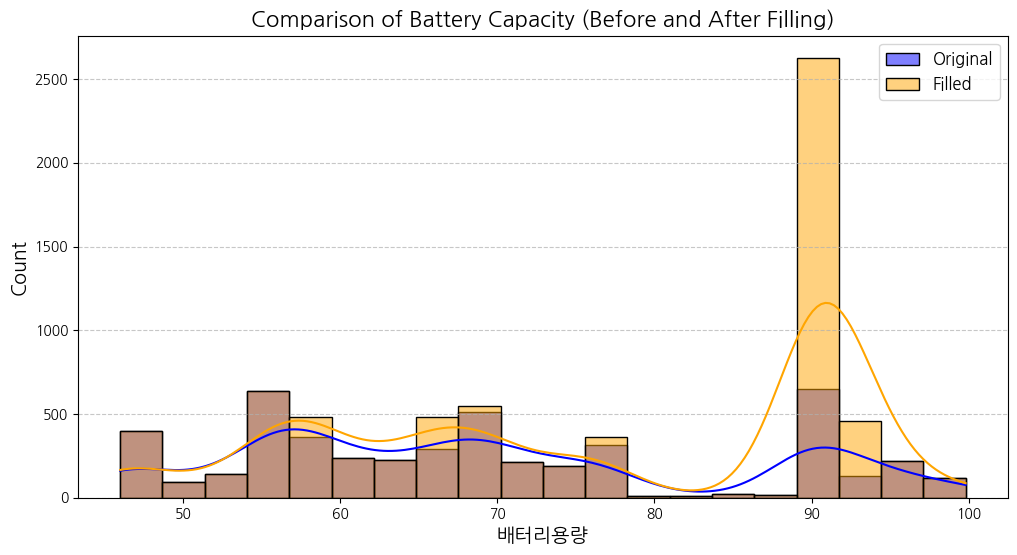

In [106]:
# 원본 데이터 복사 (결측치가 채워지기 전 데이터)
original_data = encoded_train.copy()

# 결측치 채우기
encoded_train = process_data(encoded_train)
encoded_test = process_data(encoded_test)

# 결측치 처리 결과 확인
print("Train 결측치:", encoded_train['배터리용량'].isna().sum())
print("Test 결측치:", encoded_test['배터리용량'].isna().sum())

# 그래프 비교
plt.figure(figsize=(12, 6))

# 원본 데이터의 히스토그램
sns.histplot(original_data['배터리용량'], bins=20, color='blue', kde=True, alpha=0.5, label='Original')

# 결측치 채운 데이터의 히스토그램
sns.histplot(encoded_train['배터리용량'], bins=20, color='orange', kde=True, alpha=0.5, label='Filled')

# 그래프 설정
plt.title('Comparison of Battery Capacity (Before and After Filling)', fontsize=16)
plt.xlabel('배터리용량', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 주행거리(km) 열의 로그변환

In [107]:
# 로그 변환 (log(x + 1) 사용, 0값을 처리하기 위해 1을 더함)
encoded_train['log_주행거리'] = np.log1p(encoded_train['주행거리(km)'])
encoded_test['log_주행거리'] = np.log1p(encoded_test['주행거리(km)'])

# 결과 확인
print(encoded_train[['주행거리(km)', 'log_주행거리']].head())
print(encoded_test[['주행거리(km)', 'log_주행거리']].head())

   주행거리(km)   log_주행거리
0     13642   9.520982
1     10199   9.230143
2      2361   7.767264
3     21683   9.984330
4    178205  12.090695
   주행거리(km)  log_주행거리
0     14057  9.550947
1      7547  8.929038
2      7197  8.881558
3     10357  9.245514
4      7597  8.935640


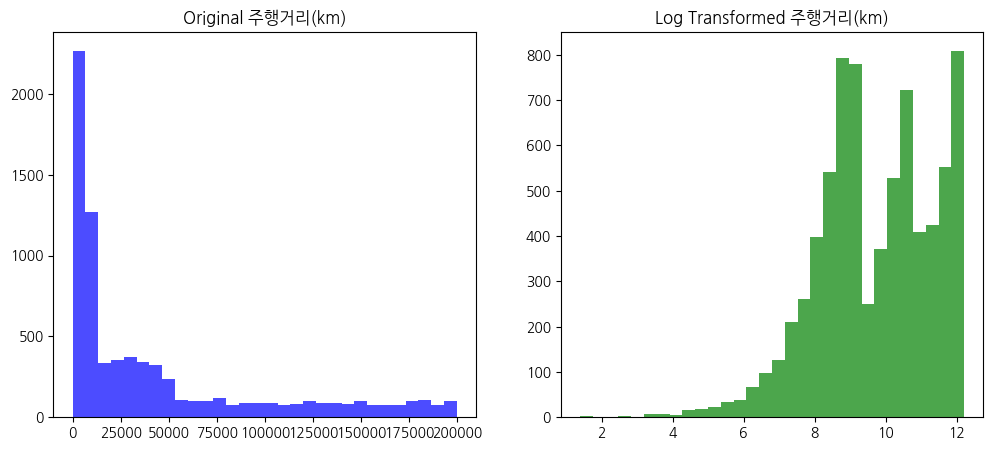

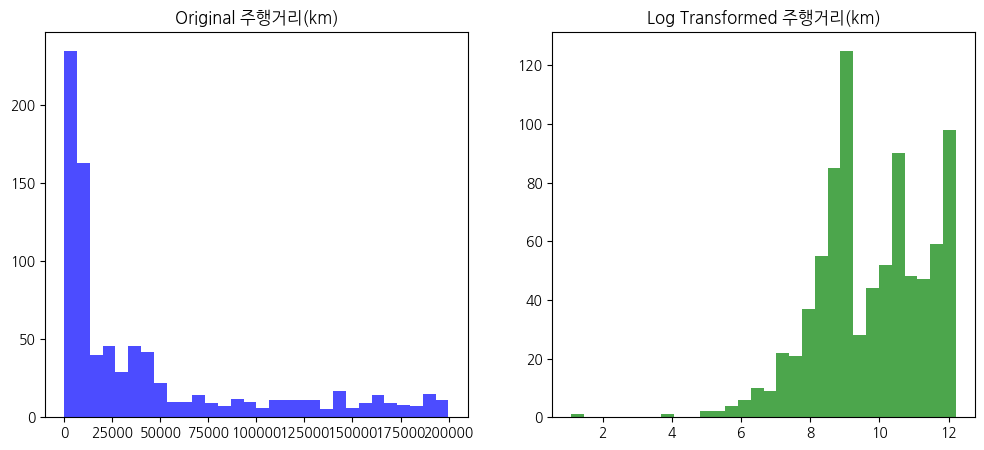

In [108]:
# 변환 전 분포
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(encoded_train['주행거리(km)'], bins=30, color='blue', alpha=0.7)
plt.title('Original 주행거리(km)')

# 변환 후 분포
plt.subplot(1, 2, 2)
plt.hist(encoded_train['log_주행거리'], bins=30, color='green', alpha=0.7)
plt.title('Log Transformed 주행거리(km)')
plt.show()

# 변환 전 분포
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(encoded_test['주행거리(km)'], bins=30, color='blue', alpha=0.7)
plt.title('Original 주행거리(km)')

# 변환 후 분포
plt.subplot(1, 2, 2)
plt.hist(encoded_test['log_주행거리'], bins=30, color='green', alpha=0.7)
plt.title('Log Transformed 주행거리(km)')
plt.show()

In [109]:
encoded_train.describe()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),BrandNew_Accident,log_주행거리
count,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,3748.000000,2.746965,10.109377,0.823663,75.833935,0.452581,44287.979458,4.960918,0.045752,0.222489,62.331949,0.020675,9.695004
std,2164.341817,1.885991,6.286307,0.833279,15.984889,0.728974,55204.064386,3.155342,0.208960,0.569232,36.646759,0.142303,1.650848
min,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,3.000000,0.000000,0.000000,0.000000,9.000000,0.000000,1.386294
25%,1874.000000,1.000000,5.000000,0.000000,61.018000,0.000000,5465.000000,2.000000,0.000000,0.000000,34.390000,0.000000,8.606302
50%,3748.000000,3.000000,11.000000,1.000000,76.093000,0.000000,17331.000000,5.000000,0.000000,0.000000,56.000000,0.000000,9.760310
75%,5622.000000,4.000000,16.000000,2.000000,91.200000,1.000000,61252.000000,8.000000,0.000000,0.000000,80.050000,0.000000,11.022768
max,7496.000000,6.000000,20.000000,2.000000,99.800000,2.000000,199827.000000,10.000000,1.000000,2.000000,161.090000,1.000000,12.205212


In [110]:
encoded_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   ID                 846 non-null    int64   
 1   제조사                846 non-null    int64   
 2   모델                 846 non-null    int64   
 3   차량상태               846 non-null    int64   
 4   배터리용량              846 non-null    float64 
 5   구동방식               846 non-null    int64   
 6   주행거리(km)           846 non-null    int64   
 7   보증기간(년)            846 non-null    int64   
 8   사고이력               846 non-null    int64   
 9   연식(년)              846 non-null    int64   
 10  BrandNew_Accident  846 non-null    int64   
 11  보증기간_구간            846 non-null    category
 12  log_주행거리           846 non-null    float64 
dtypes: category(1), float64(2), int64(10)
memory usage: 80.5 KB


### 데이터 전처리

In [111]:
# 학습과 예측을 위해 데이터를 분리합니다.
x_train = encoded_train.drop(['ID', '보증기간_구간', '주행거리(km)', '가격(백만원)'], axis = 1)
y_train = encoded_train['가격(백만원)']

x_test = encoded_test.drop(['ID', '주행거리(km)', '보증기간_구간'], axis = 1)

### 학습 및 예측하기

In [112]:
# 사용할 모델 리스트
models = {
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "LightGBM": LGBMRegressor(verbose=0),
    "CatBoost": CatBoostRegressor(verbose=0),  # CatBoost의 출력 제한
    "XGBoost": XGBRegressor(verbosity=0)  # XGBoost의 출력 제한
}

# RMSE를 스코어로 사용할 수 있도록 정의
rmse_scorer = make_scorer(root_mean_squared_error)

# 성능 결과를 저장할 딕셔너리
results = {}

# 반복문으로 모델 학습 및 평가 (교차 검증)
for name, model in models.items():
    print(f"Evaluating {name}...")
    # 교차 검증으로 성능 평가 (5-Fold)
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring=rmse_scorer)
    results[name] = np.mean(scores)
    print(f"{name} Mean RMSE: {np.mean(scores):.4f}")

# 결과 출력
print("\n모델별 교차 검증 Mean RMSE:")
for name, rmse in results.items():
    print(f"{name}: {rmse:.4f}")

Evaluating DecisionTree...
DecisionTree Mean RMSE: 1.9530
Evaluating RandomForest...
RandomForest Mean RMSE: 1.5801
Evaluating GradientBoosting...
GradientBoosting Mean RMSE: 2.9614
Evaluating LinearRegression...
LinearRegression Mean RMSE: 21.2897
Evaluating SVR...
SVR Mean RMSE: 27.3926
Evaluating KNN...
KNN Mean RMSE: 2.2549
Evaluating LightGBM...
LightGBM Mean RMSE: 1.3676
Evaluating CatBoost...
CatBoost Mean RMSE: 1.3793
Evaluating XGBoost...
XGBoost Mean RMSE: 1.4559

모델별 교차 검증 Mean RMSE:
DecisionTree: 1.9530
RandomForest: 1.5801
GradientBoosting: 2.9614
LinearRegression: 21.2897
SVR: 27.3926
KNN: 2.2549
LightGBM: 1.3676
CatBoost: 1.3793
XGBoost: 1.4559


In [113]:
# 모델을 선언하고, 학습을 진행합니다.
model = LGBMRegressor(verbose=0)
model.fit(x_train, y_train)

LGBMRegressor(verbose=0)

In [114]:
# 예측을 수행합니다.
pred = model.predict(x_test)

### 제출하기

In [115]:
# sample_submission 파일을 불러옵니다.
submit = pd.read_csv(path+'/open/sample_submission.csv')

# 예측한 결과를 submit에 저장합니다.
submit['가격(백만원)'] = pred
submit.head()

,ID,가격(백만원)
0,TEST_000,130.367586
1,TEST_001,80.044817
2,TEST_002,64.994823
3,TEST_003,35.005938
4,TEST_004,47.889913


In [116]:
# 제출을 위해 baseline_submission.csv란 이름으로 CSV 파일을 저장합니다.
submit.to_csv(path+'/submission/240127-pred18.csv',index=False)